<a href="https://colab.research.google.com/github/GrzegorzPiedel/portfolio/blob/main/Oscars%20scraper%20and%20data%20analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving oscars.zip to oscars.zip


In [2]:
import zipfile
with zipfile.ZipFile('oscars.zip', 'r') as zip_ref:
  zip_ref.extractall()

In [3]:
import os
os.listdir()

['.config', 'oscars.zip', '__MACOSX', 'output', 'sample_data']

In [4]:
from bs4 import BeautifulSoup
import pandas as pd

# Function to parse a local HTML file using BeautifulSoup
def parse_local_html(file_path):
    with open(file_path, 'r') as file:
        soup = BeautifulSoup(file, 'lxml')
        return soup

# Function to clean and extract actor/person name from nomination text
def get_actor(category_text, actor_cat):
    text = actor_cat.text.strip()

    actor = text
    if not text or text.lower() in ["nan", "-", "—"]:
        return "-"
    if "To " in text and " for " in text:
        actor = text.split("To", 1)[1].split(" for ", 1)[0].strip()
    if "To " in text and "," in text:
        actor = text.split("To", 1)[1].split(",", 1)[0].strip()
    if "To " not in text and " for " in text:
        actor = text.split(" for ", 1)[0].strip()
    if " in recognition " in text:
        actor = text.split(" in recognition ", 1)[0].strip()
    if " in appreciation " in text:
        actor = text.split(" in appreciation ", 1)[0].strip()
    if ' - "' in text:
        actor = text.split(' - "', 1)[0].strip()
    if ' – "' in text:
        actor = text.split(' – "', 1)[0].strip()

    # Remove unwanted words like "Producer", "Studio" etc.
    unwanted_words = ["(", ")", "Producers", "Producer", "Sound Director", "Studio", "Department", "Director", "Head of Department", "Adaptation Score by", "Score by", "Written by"]
    for word in unwanted_words:
        if word in actor:
            actor = actor.replace(word, "").strip()
    actor = actor.strip(',')
    actor = actor.replace("&", ",").strip()
    actor = actor.replace("  ", " ").strip()
    actor = actor.replace(" , ", ", ").strip()
    return actor

# Function to extract movie title from nomination text
def get_movie(category_text, movie_cat):
    if ' - "' in movie_cat.text:
        actor, movie = movie_cat.text.split(' - "', 1)
    else:
        movie = "-"
    return movie.strip('"')

soup = parse_local_html('output/index.html')
years = soup.select(".year-card")

list = []

# Loop through each year and extract all categories, winners, and nominees
for year in years:
    link = year.find("a")['href']
    subpage = parse_local_html('output/'+link)

    categories = subpage.select(".category-section")
    for category in categories:
        category_text = category.find("h2").text.strip()

        # Extract winners
        winners = category.select(".winner p")
        for winner in winners:

            list.append({
                "year": subpage.find("h1").text.split()[-1],
                "link": link,
                "category": category_text.title(),
                "person": get_actor(category_text, winner),
                "movie": get_movie(category, winner),
                "isWinner": True
            })

        # Extract nominees
        nominees = category.select(".nominee p")
        for nominee in nominees:

            list.append({
                "year": subpage.find("h1").text.split()[-1],
                "link": link,
                "category": category_text.title(),
                "person": get_actor(category_text, nominee),
                "movie": get_movie(category_text, nominee),
                "isWinner": False
            })

# Convert to DataFrame and save to CSV
df = pd.DataFrame(list)
df.to_csv('oscars_GP.csv', index=False)
df = pd.read_csv('oscars_GP.csv')
df

,year,link,category,person,movie,isWinner
0,2024,pages/e0e8d1fc-6525-4483-aa92-e1cc683a7a03.html,Actor In A Leading Role,Cillian Murphy,Oppenheimer,True
1,2024,pages/e0e8d1fc-6525-4483-aa92-e1cc683a7a03.html,Actor In A Leading Role,Bradley Cooper,Maestro,False
2,2024,pages/e0e8d1fc-6525-4483-aa92-e1cc683a7a03.html,Actor In A Leading Role,Colman Domingo,Rustin,False
3,2024,pages/e0e8d1fc-6525-4483-aa92-e1cc683a7a03.html,Actor In A Leading Role,Paul Giamatti,The Holdovers,False
4,2024,pages/e0e8d1fc-6525-4483-aa92-e1cc683a7a03.html,Actor In A Leading Role,Jeffrey Wright,American Fiction,False
...,...,...,...,...,...,...
10884,1928,pages/c2a21ba5-24b8-4bfa-8b21-94acee068902.html,Writing (Title Writing),Joseph Farnham,-,True
10885,1928,pages/c2a21ba5-24b8-4bfa-8b21-94acee068902.html,Writing (Title Writing),Gerald Duffy,The Private Life of Helen of Troy,False
10886,1928,pages/c2a21ba5-24b8-4bfa-8b21-94acee068902.html,Writing (Title Writing),"George Marion, Jr.",-,False
10887,1928,pages/c2a21ba5-24b8-4bfa-8b21-94acee068902.html,Special Award,Warner Bros.,-,True


In [5]:
import json

# Transform flat data into hierarchical JSON (year > categories > nominees)
structured_data = []

para_year_link = []
for wiersz in list:
    para =(wiersz["year"], wiersz["link"])
    if para not in para_year_link:
        para_year_link.append(para)

for year, link in para_year_link:
    ceremony={
        "year": year,
        "link": link,
        "categories": []
    }

    kategorie=[]
    for wiersz in list:
        if wiersz["year"] == year and wiersz["link"] == link and wiersz["category"] not in kategorie:
            kategorie.append(wiersz["category"])

    for kategoria in kategorie:
        kat_dict={
            "category": kategoria,
            "winner": [],
            "nominees": []
        }

        for wiersz in list:
            if wiersz["year"] == year and wiersz["link"]== link and wiersz["category"] == kategoria:
                osoba={
                    "person": wiersz["person"],
                    "movie": wiersz["movie"]
                }
                if wiersz["isWinner"]:
                    kat_dict["winner"].append(osoba)
                else:
                    kat_dict["nominees"].append(osoba)

        ceremony["categories"].append(kat_dict)
    structured_data.append(ceremony)

# Save hierarchical JSON
with open("oscars_GP-structured.json", "w", encoding="utf-8") as f:
    json.dump(structured_data, f, indent= 2, ensure_ascii=False)

Data analysis section:

In [6]:
# =====================
# Data analysis section
# =====================

# General statistics
print("Number of ceremonies:", df["year"].nunique())
print("Number of categories:", df["category"].nunique())
print("Number of records:", len(df))
print("Number of unique nominees (persons/groups):", df["person"].nunique())
print("Number of unique nominated movies:", df["movie"].nunique())

# Most nominated persons/groups
print("\nTop nominated persons/groups:")
top_nominacje = df["person"].value_counts().head(15)
print(top_nominacje.to_string())

# Filter function to exclude companies and countries
wyklucz = [
    "walt disney", "spain", "japan", "metro-goldwyn-mayer", "warner bros.", "paramount",
    "rko", "columbia", "fox", "italy", "france", "poland", "netherlands",
    "germany", "czechoslovakia", "sweden", "united states", "sony",
    "studio", "productions", "corporation", "pictures", "cinema", "denmark", "-"
]

def czy_osoba(nazwa):
    nazwa = str(nazwa).lower()
    for slowo in wyklucz:
        if slowo in nazwa:
            return False
    return True

# Most nominated individual persons
df_osoby = df[df["person"].apply(czy_osoba)]
top_osoby = df_osoby["person"].value_counts().head(15)
print("\nTop nominated individuals:")
print(top_osoby.to_string())

# Most nominated movies
df_filmy = df[df["movie"] != "-"]
top_filmy = df_filmy["movie"].value_counts().head(15)
print("\nTop nominated movies:")
print(top_filmy.to_string())

# Most nominated countries in Foreign Language Film
df_foreign = df[df["category"].str.upper().str.contains("FOREIGN LANGUAGE FILM")]
kraje = df_foreign["person"].value_counts().head(15)
print("\nTop nominated countries in 'Foreign Language Film':")
print(kraje.to_string())

# Nominations per decade
df["decade"] = (df["year"].astype(int) // 10) * 10
df_per_dekada = df.groupby("decade")["person"].count()
print("\nNominations per decade:")
print(df_per_dekada.to_string())
df=df.drop(columns=["decade"], errors="ignore")

# Top categories by number of nominees
nominowani_licznik = df[df["isWinner"] == False]["category"].value_counts().head(15)
print("\nCategories with the most nominees:")
print(nominowani_licznik.to_string())

# Most winning persons (excluding companies)
wygrani_licznik = df[df["person"].apply(czy_osoba)]
wygrani_licznik = wygrani_licznik[wygrani_licznik["isWinner"] == True]["person"].value_counts().head(5)
print("\nTop winners (all categories):")
print(wygrani_licznik.to_string())

# Most winning actors/actresses
kategorie_aktorskie = df["category"].str.lower()
kategorie_aktorskie = kategorie_aktorskie.str.contains("actor|actress|supporting")
df_wygrani_aktorzy_licznik = df[(df["isWinner"] == True) & kategorie_aktorskie]
df_wygrani_aktorzy_licznik = df_wygrani_aktorzy_licznik[df_wygrani_aktorzy_licznik["person"].apply(czy_osoba)]
top_aktorzy = df_wygrani_aktorzy_licznik["person"].value_counts().head(5)
print("\nTop winning actors and actresses:")
print(top_aktorzy.to_string())

Number of ceremonies: 96
Number of categories: 115
Number of records: 10889
Number of unique nominees (persons/groups): 6826
Number of unique nominated movies: 5042

Top nominated persons/groups:
person
Metro-Goldwyn-Mayer    65
Walt Disney            63
John Williams          47
Warner Bros.           45
France                 37
Alfred Newman          34
Italy                  29
Paramount              27
RKO Radio              22
Edith Head             22
Gordon Hollingshead    22
20th Century-Fox       22
Woody Allen            21
Meryl Streep           21
Spain                  21

Top nominated individuals:
person
John Williams          47
Alfred Newman          34
Edith Head             22
Gordon Hollingshead    22
Meryl Streep           21
Woody Allen            21
Victor Young           19
Leon Shamroy           17
Pete Smith             17
Max Steiner            16
Jerry Goldsmith        16
William Wyler          15
Alex North             15
Dimitri Tiomkin        14
Miklos R

Wizualizacje:

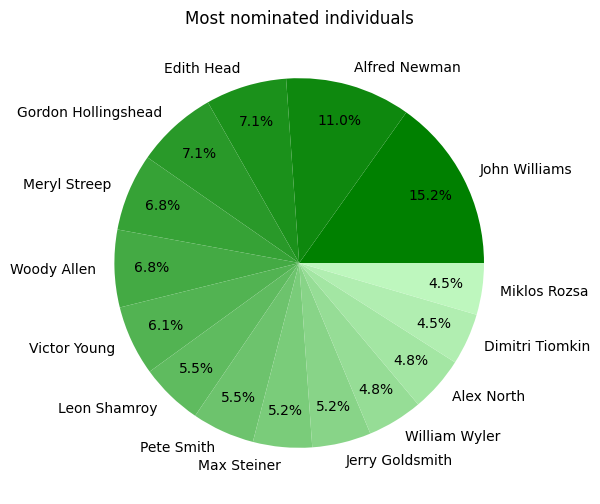

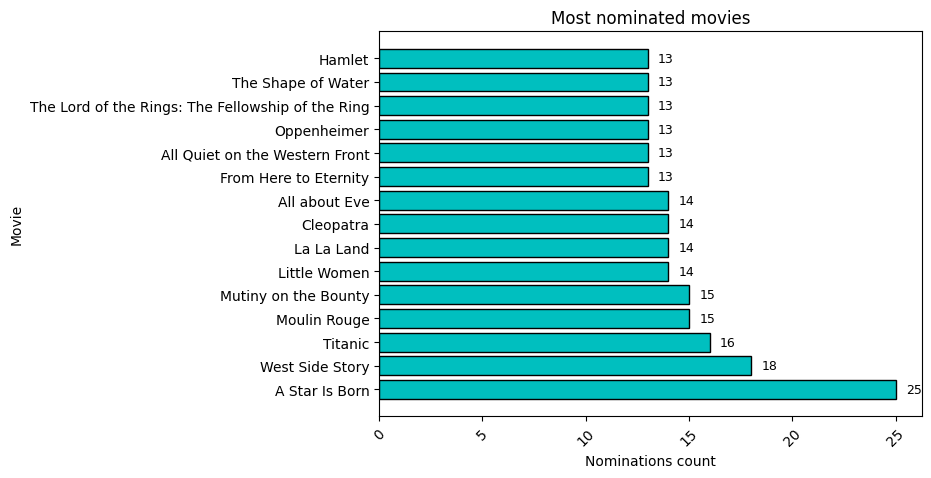

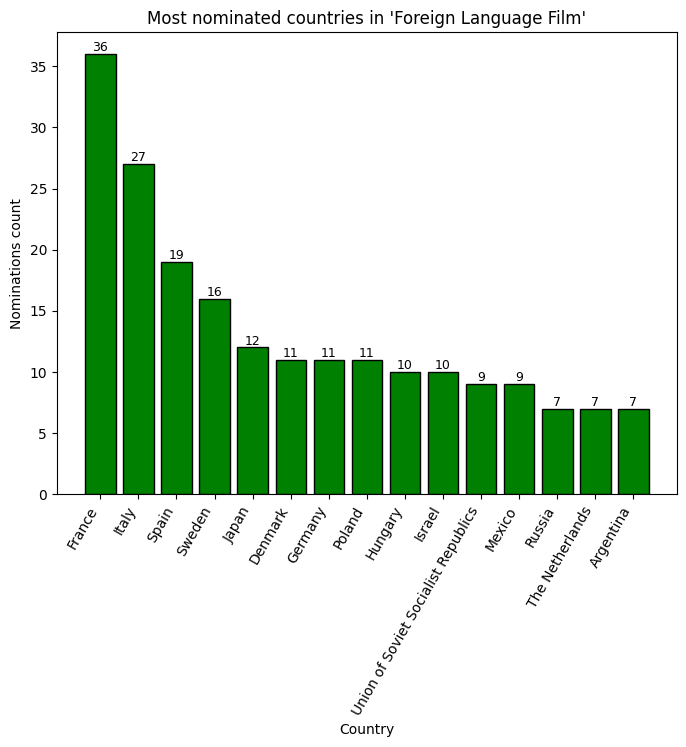

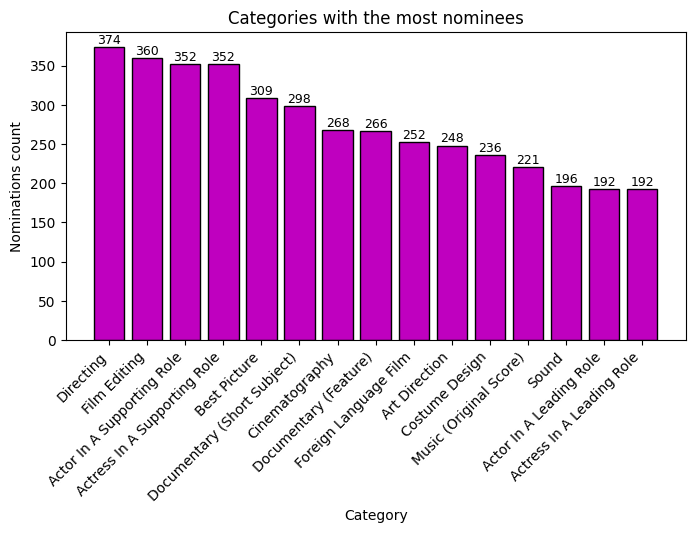

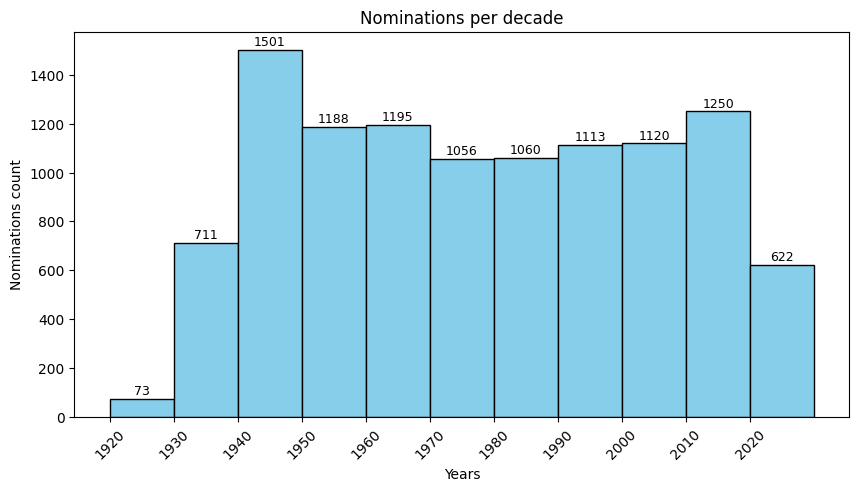

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Chart 1: Most nominated individuals
shades_of_green = 15 * [0]
for i in range(len(shades_of_green)):
    x = i / len(shades_of_green)
    shades_of_green[i] = (0.8 * x, 0.5 + x / 2, 0.8 * x)

def procenty(x):
    return f'{x:.1f}%'

plt.figure(figsize=(6, 6))
top_osoby.plot(kind="pie", autopct = procenty, colors = shades_of_green, pctdistance=0.8)
plt.title("Most nominated individuals")
plt.ylabel("")
plt.show()
print('\n')

# Chart 2: Most nominated movies
top_filmy_df = top_filmy.reset_index()
top_filmy_df.columns = ['movie', 'nominations count']

plt.figure(figsize=(7, 5))
bars = plt.barh(top_filmy_df['movie'], top_filmy_df['nominations count'], color ='c', ec ='black')
plt.title("Most nominated movies")
plt.xlabel("Nominations count")
plt.ylabel("Movie")
plt.xticks(rotation=45)

for bar, liczba in zip(bars, top_filmy_df['nominations count']):
    plt.text(
        x =bar.get_width() + 0.5,
        y = bar.get_y() + bar.get_height() / 2,
        s = f'{liczba:}',
        va='center',
        fontsize=9
    )

plt.show()
print('\n')

# Chart 3: Most nominated countries in Foreign Language Film
kraje_df = kraje.reset_index()
kraje_df.columns = ['country', 'nominations count']

plt.figure(figsize=(8, 6))
bars = plt.bar(kraje_df['country'], kraje_df['nominations count'], color='green', ec='black')
plt.title("Most nominated countries in 'Foreign Language Film'")
plt.xlabel("Country")
plt.ylabel('Nominations count')
plt.xticks(rotation=60, ha='right')

for bar, liczba in zip(bars, kraje_df['nominations count']):
    plt.text(
        x = bar.get_x() + bar.get_width() / 2,
        y = bar.get_height(),
        s = f'{liczba}',
        ha ='center',
        va ='bottom',
        fontsize=9
    )

plt.show()
print('\n')

# Chart 4: Categories with the most nominees
nominowani_licznik_df = nominowani_licznik.reset_index()
nominowani_licznik_df.columns = ['category', 'nominations count']

plt.figure(figsize=(8, 4))
bars = plt.bar(nominowani_licznik_df['category'], nominowani_licznik_df['nominations count'], color='m', ec='black')
plt.title("Categories with the most nominees")
plt.xlabel("Category")
plt.ylabel("Nominations count")
plt.xticks(rotation=45, ha='right')

for bar, liczba in zip(bars, nominowani_licznik_df['nominations count']):
    plt.text(
        x = bar.get_x() + bar.get_width() / 2,
        y = bar.get_height()+ 0.5,
        s = f'{liczba}',
        ha = 'center',
        va = 'bottom',
        fontsize=9
    )

plt.show()
print('\n')

# Chart 5: Nominations per decade
dekady =df_per_dekada.index.astype(int)
liczby =df_per_dekada.values

plt.figure(figsize=(10, 5))
bars = plt.bar(dekady, liczby, width=10, align='edge', color='skyblue', edgecolor='black')
plt.title("Nominations per decade")
plt.xlabel("Years")
plt.ylabel('Nominations count')
plt.xticks(dekady, rotation=45)

for bar, liczba in zip(bars, liczby):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 5,
        str(liczba),
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.show()

# Summary of data anomalies:

a) Missing or unclear data:
- Missing movie titles ('-')
- Missing or unreadable persons ('-' or NaN)

b) Duplicate or inconsistent persons:
- Same person appears in multiple variants (e.g. 'Walt Disney' vs 'Disney')
- Sometimes institutions/countries appear as persons (e.g. 'France', 'Sony')

c) Ambiguous category names:
- Categories are not consistent across years (e.g. 'Actor In A Leading Role' vs 'Leading Actor')
- Regex-based filtering (e.g. str.contains("actor|actress")) is required

# Potential applications:
1. Interactive API or web application for Oscars database
2. Dashboard visualizations for exploring nominations and winners
3. Machine learning models for predicting future winners
"""

Database implementation

In [8]:
import sqlite3

db_path = "oscars_relational.sqlite"

conn = sqlite3.connect(db_path)
cur = conn.cursor()

cur.executescript("""
DROP TABLE IF EXISTS nominations;
DROP TABLE IF EXISTS persons;
DROP TABLE IF EXISTS movies;
DROP TABLE IF EXISTS categories;
DROP TABLE IF EXISTS ceremonies;

CREATE TABLE persons (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT UNIQUE
);

CREATE TABLE movies (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    title TEXT UNIQUE
);

CREATE TABLE categories (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT UNIQUE
);

CREATE TABLE ceremonies (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    year INTEGER,
    link TEXT UNIQUE
);

CREATE TABLE nominations (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    person_id INTEGER,
    movie_id INTEGER,
    category_id INTEGER,
    ceremony_id INTEGER,
    isWinner BOOLEAN,
    FOREIGN KEY (person_id) REFERENCES persons(id),
    FOREIGN KEY (movie_id) REFERENCES movies(id),
    FOREIGN KEY (category_id) REFERENCES categories(id),
    FOREIGN KEY (ceremony_id) REFERENCES ceremonies(id)
);
""")
print("Database schema created.")

Database schema created.


In [9]:
# Insert unique persons
unique_persons=df[['person']].drop_duplicates()

for _, row in unique_persons.iterrows():
    cur.execute("""
    INSERT INTO persons (name)
    VALUES (?)
    """, (row['person'],))
print("Inserted data into 'persons'")

# Insert unique movies
unique_movies = df[['movie']].drop_duplicates()

for _, row in unique_movies.iterrows():
    cur.execute("""
    INSERT INTO movies (title)
    VALUES (?)
    """, (row['movie'],))
print("Inserted data into 'movies'")

# Insert unique categories
unique_categories = df[['category']].drop_duplicates()

for _, row in unique_categories.iterrows():
    cur.execute("""
    INSERT INTO categories (name)
    VALUES (?)
    """, (row['category'],))
print("Inserted data into 'categories'")

# Insert unique ceremonies
unique_ceremonies =df[['year', 'link']].drop_duplicates()

for _, row in unique_ceremonies.iterrows():
    cur.execute("""
    INSERT INTO ceremonies (year, link)
    VALUES (?, ?)
    """, (row['year'], row['link']))
print("Inserted data into 'ceremonies'")

Inserted data into 'persons'
Inserted data into 'movies'
Inserted data into 'categories'
Inserted data into 'ceremonies'


In [10]:
# Insert all nominations
for _, row in df.iterrows():
    cur.execute("SELECT id FROM persons WHERE name = ?", (row['person'],))
    person_id = cur.fetchone()[0]

    cur.execute("SELECT id FROM movies WHERE title = ?", (row['movie'],))
    movie_id = cur.fetchone()[0]

    cur.execute("SELECT id FROM categories WHERE name = ?", (row['category'],))
    category_id = cur.fetchone()[0]

    cur.execute("SELECT id FROM ceremonies WHERE year = ?", (row['year'],))
    ceremony_id = cur.fetchone()[0]

    # Insert into nominations
    cur.execute("""
        INSERT INTO nominations (person_id, movie_id, category_id, ceremony_id, isWinner)
        VALUES (?, ?, ?, ?, ?)
    """, (person_id, movie_id, category_id, ceremony_id, row['isWinner']))

print("Inserted data into 'nominations'")

conn.commit()
conn.close()

Inserted data into 'nominations'
